# TM10007 Group 4 -- ECG Data

Hallo tekst

In [2]:
# Loading packages
import zipfile
import os
import pandas as pd
import sklearn as sk





## 1. Data loading, cleaning and visualization

Below we load the ECG data, convert it to a dataframe an clean the data.First we are going to start with loading the CS file into a dataframe

In [4]:
# Load CSV file into dataframe
!git clone https://github.com/JosefienBerg/TM10007_ML_ECG_group4.git

with zipfile.ZipFile('/content/TM10007_ML_ECG_group4/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TM10007_ML_ECG_group4/ecg')

data = pd.read_csv('/content/TM10007_ML_ECG_group4/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(data)

Cloning into 'TM10007_ML_ECG_group4'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 159 (delta 47), reused 54 (delta 36), pack-reused 82
Receiving objects: 100% (159/159), 67.95 MiB | 41.49 MiB/s, done.
Resolving deltas: 100% (71/71), done.
The number of samples: 827
The number of columns: 9001
            0_0         0_1         0_2        0_3        0_4         0_5  \
0     47.685046   48.416904   37.371002  61.604757  58.732738  213.067966   
1    152.726718  297.353726  111.168880  25.419423  14.636085   24.609688   
2      1.601260    3.882169   22.978997  21.673040   8.919484   18.329286   
3      1.388947    3.052483    3.084103   4.627886  10.016196   15.020347   
4      3.625561    3.728466    6.205367  17.722897   5.699401    9.024836   
..          ...         ...         ...        ...        ...         ...   
822   14.673713   13.879148   10.000083   8.337630   3.55730

Now we are going to test if there is data missing in our dataset. We conclude that NaNs are missing data and if an entire row or column has zero's, this is also seen as missing data.

In [ ]:
# Checking if there are any NaN or None values in the dataset
print(f'Are there any NaN or None values in the dataset? = '+ str(data.isnull().values.any()))

Are there any NaN or None values in the dataset? = False


In [ ]:
# Test dataset for missing rows/columns

# Columns
columnswithzeros = []
for (colname, colval) in data.iteritems():
  if (colval==0).all() == True:
    print(f'All values are zero in column {colname}')
    columnswithzeros.append(colname)

if len(columnswithzeros) == 0:
  print('There are no columns with only zeros')
  
# Rows
rowswithzeros = []
for (index, rowval) in data.iterrows():
  if (rowval==0).all() == True: 
    print(f'All values are zero in row {index}')
    rowswithzeros.append(index)

if len(rowswithzeros) == 0:
  print('There are no rows with only zeros')

There are no columns with only zeros
There are no rows with only zeros


In [ ]:
# Cleaning dataset

Visualisation of the datasset

In [ ]:
# How many patients have a normal or abnormal ECG?
count0= (data['label'] == 0).sum()
count1= (data['label'] == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')

# Since the majority of patients has no abnormalities we can conclude that label 0 is normal and label 1 is abnormal

There are 681 patients with label 0
There are 146 patients with label 1


In [ ]:
# Visualisation of feature space


## 2. Creating the experimental setup
Below we split the dataset in test data and training data. Then we further split the trainingdata in order to make different training and validation sets for our different classifiers

In [5]:
# Initial split

# packages 
from sklearn.model_selection import train_test_split

# split the whole data set in a training and test set
col = "label"
x_train, x_test, y_train, y_test = train_test_split (data.loc[:, data.columns !=col], data.loc[:, "label"].values, train_size = 0.8, random_state = 42) 
print(x_train)

             0_0         0_1         0_2         0_3         0_4         0_5  \
529    26.094388  145.213783  247.539256  304.761407  164.956864  119.939717   
596     5.569268    8.787120    3.221415    3.027610    1.661665   10.362930   
396     7.476934   20.834738    8.550020    9.199971    8.882476    8.734514   
814     9.161071    1.906232    5.714063   15.832251   24.006140   32.987560   
723     1.925831    1.688467    7.624057   11.630483   12.237969    3.831897   
..           ...         ...         ...         ...         ...         ...   
71   1072.494116   82.493852   46.458215   87.448854  108.303842  110.689626   
106     2.411066    3.573233    3.611470    1.462549   23.036692   43.618778   
270    16.049135   14.823699   16.312268    7.789727   30.994297   93.770550   
435  1103.484470   49.176909    7.973782    9.150286    9.992629    4.018226   
102  1706.885360  260.031343   51.262493   37.922200   29.359422   24.076905   

            0_6         0_7        0_8 

## Hyperparameter tuning and cross validation 

**ALLEEN OPZET, NOG NIET VOOR ONS PROJECT AANGEPAST**

In [ ]:

random_state = 42
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=random_state),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(random_state=random_state),
    "LogisticRegression": LogisticRegression(random_state=random_state),
}

n_splits = 5
model_parameters = {
    "DecisionTreeClassifier": {
        "max_depth": [None],
        "min_samples_leaf": [2],
        "random_state": [42],
    },
    "KNeighborsClassifier": {"n_neighbors": [3], "weights": ["distance"]},
    "SVC": {"C": [10], "kernel": ["poly"], "random_state": [42]},
    "LogisticRegression": {
        "C": [10],
        "penalty": ["none"],
        "random_state": [42],
    },
}

accuracies_without_tune = []
searches_without_tune = []
for name, parameters in model_parameters.items():
    model = models[name]

    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    grid_search = GridSearchCV(
        model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring="accuracy"
    ).fit(X, y)
    accuracies_without_tune.append(grid_search.score(X_tst, y_tst))
    searches_without_tune.append(grid_search)


hallo text

Amount of diseased patients: 146


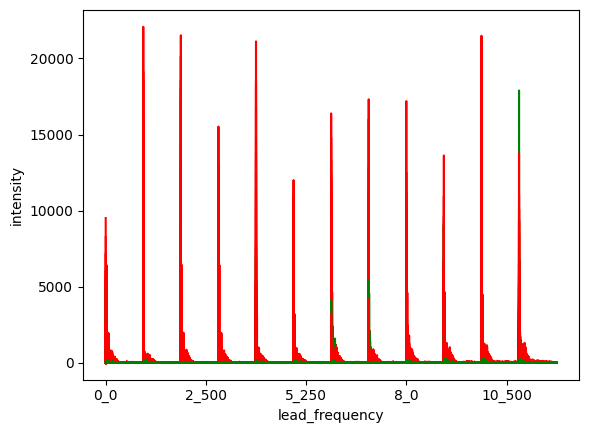

In [16]:
# Extra blokje

# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import plotly.express as px

# pca = PCA(n_components=2)
# pca.fit(x_train)
# components = pca.transform(x_train)

# import plotly.express as px
# from sklearn.decomposition import PCA

# n_components = 8

# pca = PCA(n_components=n_components)
# components = pca.fit_transform(data)

# total_var = pca.explained_variance_ratio_.sum() * 100

# labels = {str(i): f"PC {i+1}" for i in range(n_components)}
# labels['color'] = 'Median Price'

# fig = px.scatter_matrix(
#     components,
#     color=data.label,
#     dimensions=range(n_components),
#     labels=labels,
#     title=f'Total Explained Variance: {total_var:.2f}%',
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()


## 3. Feature scaling

Hallo tekst

In [ ]:
# Blokje 1

Hallo tekst

In [ ]:
# Blokje 2

Hallo tekst

In [ ]:
# Blokje 3

## 4. Feature selection

Hallo tekst

In [ ]:
# Blokje 1

Hallo tekst

In [ ]:
# Blokje 2

Hallo tekst

In [ ]:
# Blokje 3